In [377]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#import datasets
bos_calendar = pd.read_csv('boston/calendar.csv')
bos_listing = pd.read_csv('boston/listings.csv')
bos_review = pd.read_csv('boston/reviews.csv')
sea_calendar = pd.read_csv('seattle/calendar.csv')
sea_listing = pd.read_csv('seattle/listings.csv')
sea_review = pd.read_csv('seattle/reviews.csv')

In [77]:
def completeColumns(df):
    return list(df.columns[df.isnull().sum() == 0])

def missingColumns(df, val):
    return list(df.columns[df.isnull().sum() / df.shape[0] >= val])

def missingPct(df1, df2, col):
    p1 = df1[col].isnull().sum() / df1.shape[0] 
    p2 = df2[col].isnull().sum() / df2.shape[0] 
    print(f"df1 missing pct {p1}, df2 missing pct {p2}")

In [97]:
# clean data
def priceClean(s):
    if pd.isnull(s):
        return None
    else:
        return int(float(s.replace(",","").replace("$","")))

In [ ]:
# some feature selection explore

In [405]:
bos_listing.columns[bos_listing.nunique() == 1]

Index(['scrape_id', 'last_scraped', 'experiences_offered', 'city', 'state',
       'country_code', 'country', 'calendar_last_scraped', 'requires_license'],
      dtype='object')

In [406]:
sea_listing.columns[sea_listing.nunique() == 1]

Index(['scrape_id', 'last_scraped', 'experiences_offered', 'city', 'market',
       'country_code', 'country', 'has_availability', 'calendar_last_scraped',
       'requires_license', 'jurisdiction_names'],
      dtype='object')

In [407]:
# columns with only 1 value can be dropped

In [13]:
sea_listing.host_response_time.value_counts()

within an hour        1692
within a few hours     968
within a day           597
a few days or more      38
Name: host_response_time, dtype: int64

In [14]:
bos_listing.host_response_time.value_counts()

within an hour        1384
within a few hours    1218
within a day           469
a few days or more      43
Name: host_response_time, dtype: int64

In [12]:
(bos_listing.host_listings_count != bos_listing.host_total_listings_count).sum()

0

In [19]:
bos_listing[['host_listings_count', 'host_total_listings_count']].isnull().sum()

host_listings_count          0
host_total_listings_count    0
dtype: int64

In [15]:
(sea_listing.host_listings_count != sea_listing.host_total_listings_count).sum()

2

In [18]:
sea_listing[['host_listings_count', 'host_total_listings_count']].isnull().sum()

host_listings_count          2
host_total_listings_count    2
dtype: int64

In [22]:
sea_listing[sea_listing.host_id == 1075031]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1419,10235014,https://www.airbnb.com/rooms/10235014,20160104002432,2016-01-04,Luxury Apartment in Belltown / SLU,Beautiful building near the heart of downtown ...,NaN,Beautiful building near the heart of downtown ...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN


In [21]:
sea_listing.host_listings_count.value_counts()

1.0      2179
2.0       620
3.0       261
4.0       151
5.0        98
34.0       67
6.0        48
48.0       46
169.0      39
37.0       37
36.0       36
7.0        30
9.0        28
10.0       26
8.0        23
11.0       22
21.0       21
18.0       19
17.0       16
13.0       12
12.0       12
354.0      10
19.0        4
163.0       4
15.0        3
502.0       2
84.0        2
Name: host_listings_count, dtype: int64

In [ ]:
# basically host_listings_count is the same with host_total_listings_count
# 2 unmathced ones in seattle are nulls in host_listings_count and host_total_listings_count
# can fill na with mode

In [26]:
sea_listing.host_neighbourhood.isnull().sum() / sea_listing.shape[0]
# don't include host_neighbourhood, missing value ~8%, not a very good feature either
# use neighbourhood as a listing geo location feature

0.0785751702462022

In [27]:
bos_listing.host_has_profile_pic.value_counts()

t    3577
f       8
Name: host_has_profile_pic, dtype: int64

In [29]:
sea_listing.host_has_profile_pic.value_counts()

t    3809
f       7
Name: host_has_profile_pic, dtype: int64

In [30]:
# majority of hosts has their profile picture, which means no diff here, exclude

In [33]:
bos_listing.host_identity_verified.isnull().sum()

0

In [34]:
sea_listing.host_identity_verified.isnull().sum()

2

In [35]:
sea_listing.host_identity_verified.value_counts()

t    2997
f     819
Name: host_identity_verified, dtype: int64

In [36]:
# 2 missing values, could fill na with mode

In [42]:
missingPct(bos_listing, 'zipcode')

0.010599721059972107

In [43]:
missingPct(sea_listing, 'zipcode')

0.0018334206390780514

In [62]:
def check(df, group, check_col):
    '''
    check if @check_col can be potentially fillna with aggregated value in @group
    df - dataframe
    group - string
    check_col - string
    '''
    nulls = df[df[check_col].isnull()][group].unique()
    not_nulls = df[df[check_col].notnull()][group].unique()
    for i in nulls:
        if i not in not_nulls:
            return False
        return True

In [63]:
check(bos_listing, 'neighbourhood_cleansed', 'zipcode')

True

In [64]:
check(sea_listing, 'neighbourhood_cleansed', 'zipcode')

True

In [65]:
check(sea_listing, 'neighbourhood_group_cleansed', 'zipcode')

True

In [ ]:
# zipcode can be filled with mode zipcode in neighborhood

In [67]:
missingPct(bos_listing, 'is_location_exact')

0.0

In [68]:
missingPct(sea_listing, 'is_location_exact')

0.0

In [69]:
missingPct(bos_listing, 'property_type')

0.0008368200836820083

In [70]:
missingPct(sea_listing, 'property_type')

0.00026191723415400735

In [73]:
# property_type can be filled with mode

In [71]:
missingPct(bos_listing, 'room_type')

0.0

In [72]:
missingPct(sea_listing, 'room_type')

0.0

In [76]:
missingPct(bos_listing, sea_listing, 'accommodates')

df1 missing pct 0.0, df2 missing pct 0.0


In [78]:
completeColumns(bos_listing)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'description',
 'experiences_offered',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood_cleansed',
 'state',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'room_type',
 'accommodates',
 'bed_type',
 'amenities',
 'price',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'requires_license',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count']

In [79]:
completeColumns(sea_listing)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'description',
 'experiences_offered',
 'picture_url',
 'host_id',
 'host_url',
 'host_verifications',
 'street',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'room_type',
 'accommodates',
 'bed_type',
 'amenities',
 'price',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'calculated_host_listings_count']

In [80]:
missingPct(bos_listing, sea_listing, 'bathrooms')

df1 missing pct 0.003905160390516039, df2 missing pct 0.0041906757464641176


In [81]:
bos_listing.bathrooms.value_counts()

1.0    2751
2.0     478
1.5     208
2.5      68
3.0      21
0.0      13
3.5      13
0.5       7
5.0       5
6.0       4
4.0       2
4.5       1
Name: bathrooms, dtype: int64

In [82]:
sea_listing.bathrooms.value_counts()

1.0    2882
2.0     373
1.5     248
2.5     124
3.0      64
3.5      57
0.5      31
4.0       8
0.0       8
4.5       3
8.0       2
5.0       2
Name: bathrooms, dtype: int64

In [ ]:
# bathrooms can fill with mode

In [83]:
missingPct(bos_listing, sea_listing, 'bedrooms')

df1 missing pct 0.002789400278940028, df2 missing pct 0.001571503404924044


In [84]:
bos_listing.bedrooms.value_counts()

1.0    2379
2.0     693
0.0     287
3.0     155
4.0      45
5.0      16
Name: bedrooms, dtype: int64

In [ ]:
# bedrooms can fill with mode

In [86]:
missingPct(bos_listing, sea_listing, 'beds')

df1 missing pct 0.002510460251046025, df2 missing pct 0.00026191723415400735


In [87]:
bos_listing.beds.value_counts()

1.0     2165
2.0      953
3.0      275
4.0      106
5.0       40
6.0       16
7.0        8
8.0        6
0.0        4
9.0        2
16.0       1
Name: beds, dtype: int64

In [88]:
sea_listing.beds.value_counts()

1.0     2201
2.0      912
3.0      433
4.0      152
5.0       73
6.0       21
7.0       14
9.0        4
8.0        4
10.0       2
15.0       1
Name: beds, dtype: int64

In [ ]:
# beds fill na with mode

In [89]:
bos_listing.bed_type.value_counts()

Real Bed         3453
Futon              51
Airbed             40
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64

In [90]:
missingPct(bos_listing, sea_listing, 'review_scores_rating')

df1 missing pct 0.22677824267782426, df2 missing pct 0.16946045049764275


In [93]:
bos_listing.review_scores_rating.nunique()

48

In [94]:
# treat it as a categorical variable might create too many dummy variables
# see if can be group by 5 or 10 score range

In [98]:
bos_listing['price_cleansed'] = bos_listing.price.apply(priceClean)

<Axes: xlabel='review_scores_rating'>

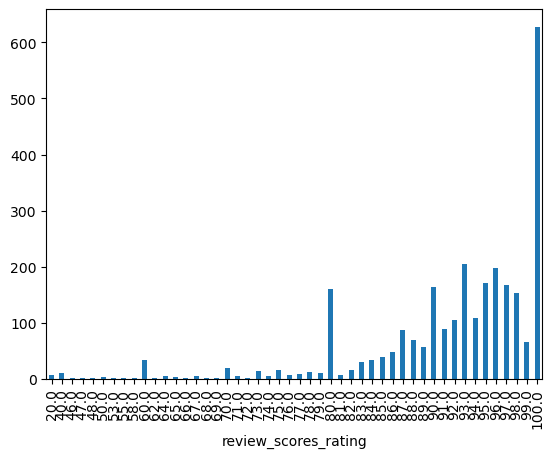

In [136]:
bos_listing.groupby('review_scores_rating').id.count().plot(kind='bar')

In [142]:
bos_listing[bos_listing.review_scores_rating < 80].count()

id                                175
listing_url                       175
scrape_id                         175
last_scraped                      175
name                              175
                                 ... 
calculated_host_listings_count    175
reviews_per_month                 175
price_cleansed                    175
review_score_group                175
review_score_group_5              175
Length: 98, dtype: int64

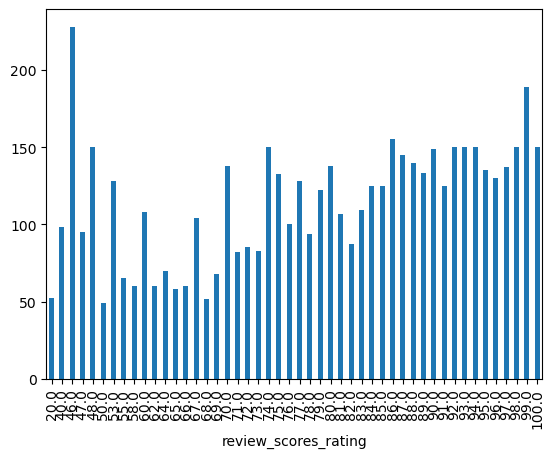

In [157]:
bos_listing.groupby('review_scores_rating').price_cleansed.median().plot(kind='bar');

In [120]:
sea_listing['price_cleansed'] = sea_listing.price.apply(priceClean)

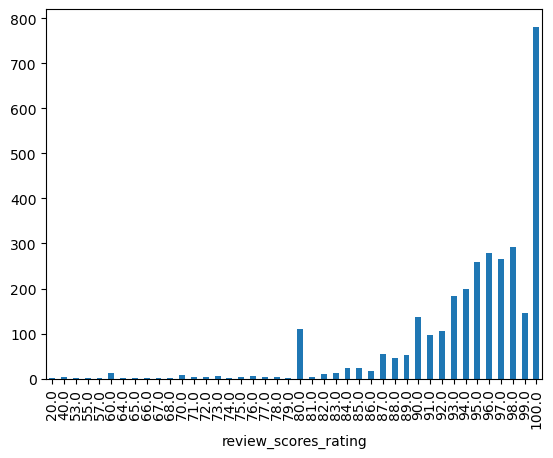

In [156]:
sea_listing.groupby('review_scores_rating').id.count().plot(kind='bar');

In [145]:
sea_listing[sea_listing.review_scores_rating < 80].count()

id                                  70
listing_url                         70
scrape_id                           70
last_scraped                        70
name                                70
                                    ..
require_guest_phone_verification    70
calculated_host_listings_count      70
reviews_per_month                   70
price_cleansed                      70
review_score_group                  70
Length: 94, dtype: int64

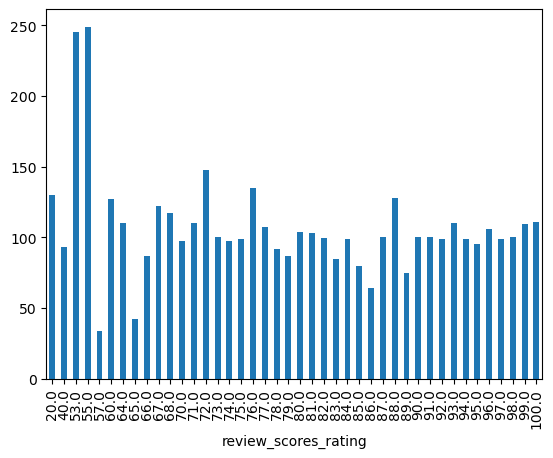

In [155]:
sea_listing.groupby('review_scores_rating').price_cleansed.median().plot(kind='bar');

In [140]:
# from review score distribution, below 80 can be grouped into a few buckets, [0, 59],[60, 69],[70, 79]

In [334]:
def create_review_category(df):
    # Define the bin edges and labels
    bin_edges = [0, 59, 69, 79, 80] + list(range(81, 101))
    bin_labels = ['0-59', '60-69', '70-79'] + list(range(80, 101))

    # Cut the numerical column into categorical groups
    df['review_score_group'] = pd.cut(df['review_scores_rating'], bins=bin_edges, labels=bin_labels)
    # fill missing value with 'N/A'
    df['review_score_group'] = df['review_score_group'].cat.add_categories('N/A')
    df['review_score_group'] = df['review_score_group'].fillna('N/A')

In [153]:
create_review_category(bos_listing)
create_review_category(sea_listing)

In [152]:
bos_listing.review_score_group.value_counts(dropna=False)

NaN      813
100      628
93       205
96       197
95       171
97       168
90       163
80       160
98       153
94       109
92       105
70-79     97
91        88
87        87
88        69
99        65
89        56
60-69     51
86        47
85        39
84        34
83        30
0-59      27
82        16
81         7
Name: review_score_group, dtype: int64

In [154]:
sea_listing.review_score_group.value_counts(dropna=False)

100      781
NaN      647
98       292
96       278
97       266
95       260
94       198
93       184
99       146
90       138
80       111
92       105
91        97
87        55
89        53
88        47
70-79     42
85        24
84        23
60-69     20
86        17
83        13
82        10
0-59       8
81         3
Name: review_score_group, dtype: int64

In [184]:
def check_category_column(df1, df2, category_col, check_col='price_cleansed'):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    # plot histogram
    histo = df1.groupby([category_col]).id.count().reset_index(name='counts')
    axs[0,0].bar(histo[category_col], height=histo['counts'])
    axs[0,0].set_xlabel(category_col)
    axs[0,0].set_ylabel('Frequency')
    axs[0,0].set_title('Boston Histogram')
    
    # plot bar chart
    grouped = df1.groupby(category_col)[check_col].median().reset_index();
    axs[0,1].bar(grouped[category_col], height=grouped[check_col])
    axs[0,1].set_xlabel(category_col)
    axs[0,1].set_ylabel(check_col + ' median')
    axs[0,1].set_title('Boston Bar Chart')
    
    # plot histogram
    histo = df2.groupby([category_col]).id.count().reset_index(name='counts')
    axs[1,0].bar(histo[category_col], height=histo['counts'])
    axs[1,0].set_xlabel(category_col)
    axs[1,0].set_ylabel('Frequency')
    axs[1,0].set_title('Seattle Histogram')
    
    # plot bar chart
    grouped = df2.groupby(category_col)[check_col].median().reset_index();
    axs[1,1].bar(grouped[category_col], height=grouped[check_col])
    axs[1,1].set_xlabel(category_col)
    axs[1,1].set_ylabel(check_col + ' median')
    axs[1,1].set_title('Seattle Bar Chart')

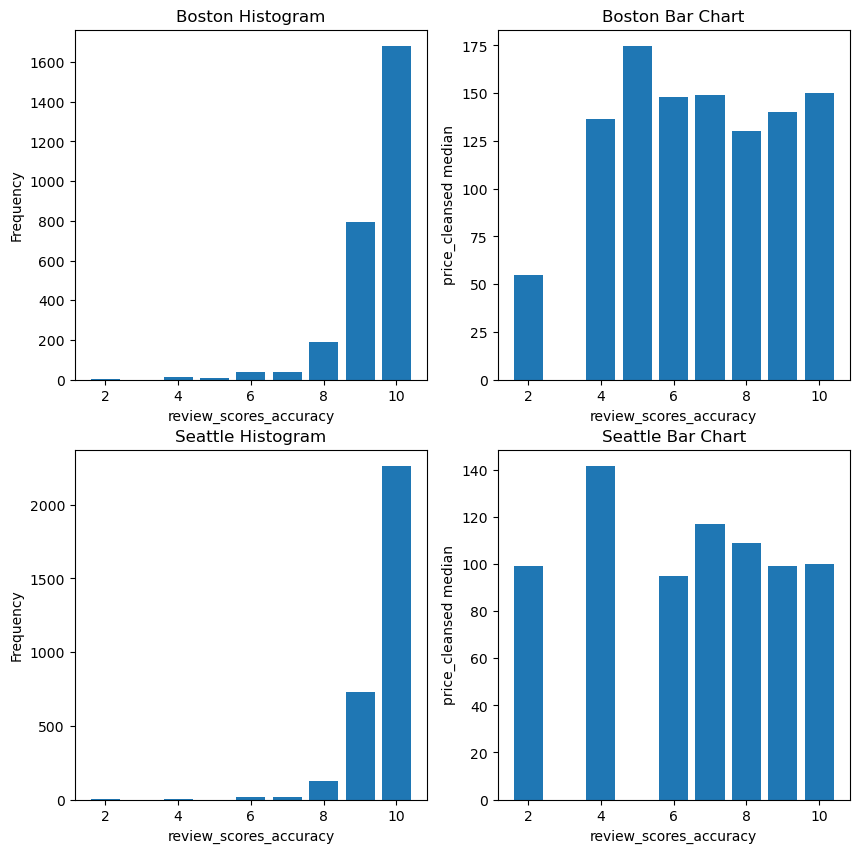

In [185]:
check_category_column(bos_listing, sea_listing, 'review_scores_accuracy')
# no clear trends on accuracy review

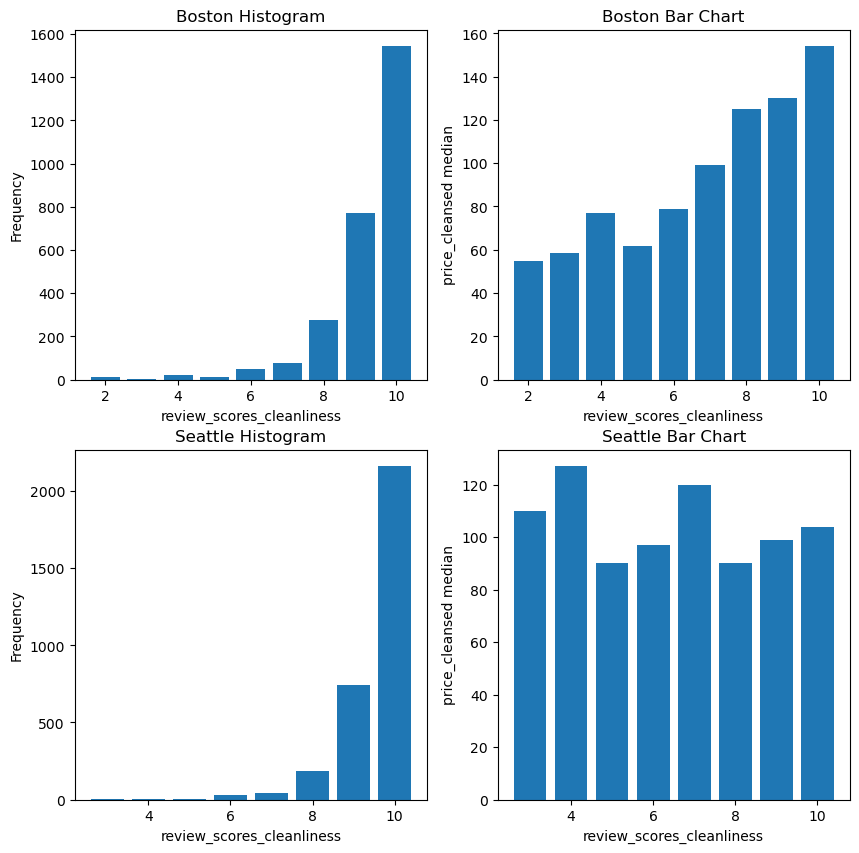

In [186]:
check_category_column(bos_listing, sea_listing, 'review_scores_cleanliness')

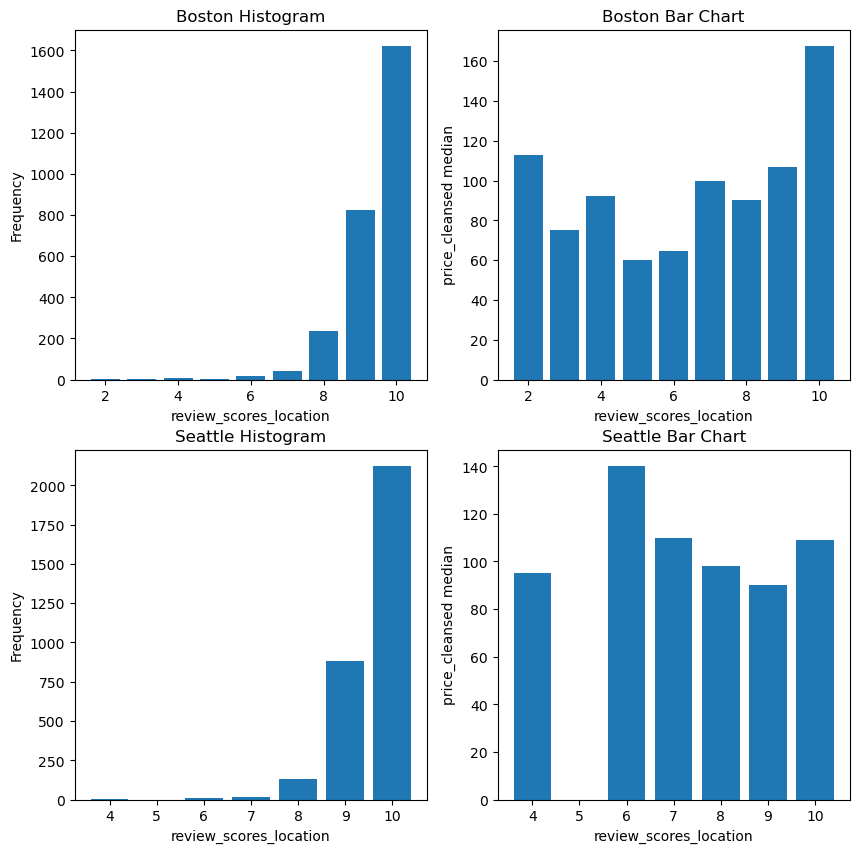

In [191]:
check_category_column(bos_listing, sea_listing, 'review_scores_location')

In [193]:
bos_listing.requires_license.value_counts()

f    3585
Name: requires_license, dtype: int64

In [194]:
sea_listing.requires_license.value_counts()

f    3818
Name: requires_license, dtype: int64

In [195]:
# only 1 value in requires_license, exclude

In [199]:
bos_listing.cancellation_policy.value_counts()

strict             1582
flexible            999
moderate            919
super_strict_30      85
Name: cancellation_policy, dtype: int64

In [207]:
bos_listing.select_dtypes(include='number').columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month',
       'price_cleansed'],
      dtype='object')

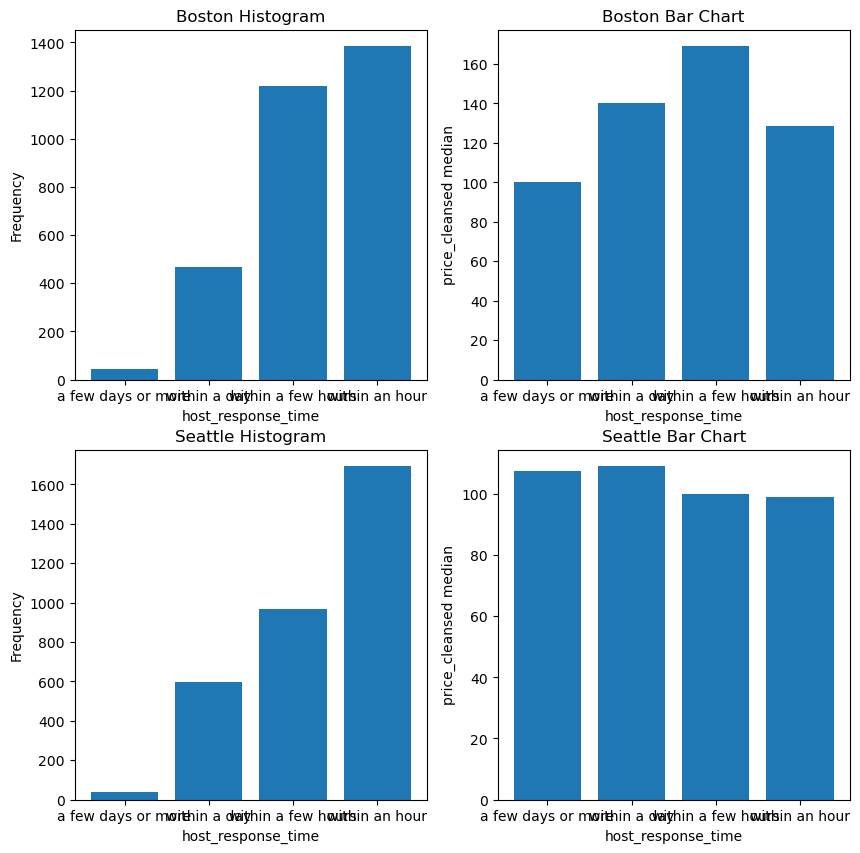

In [236]:
check_category_column(bos_listing, sea_listing, 'host_response_time')

In [224]:
numerical_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds',
      'guests_included', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month',
       'price_cleansed']

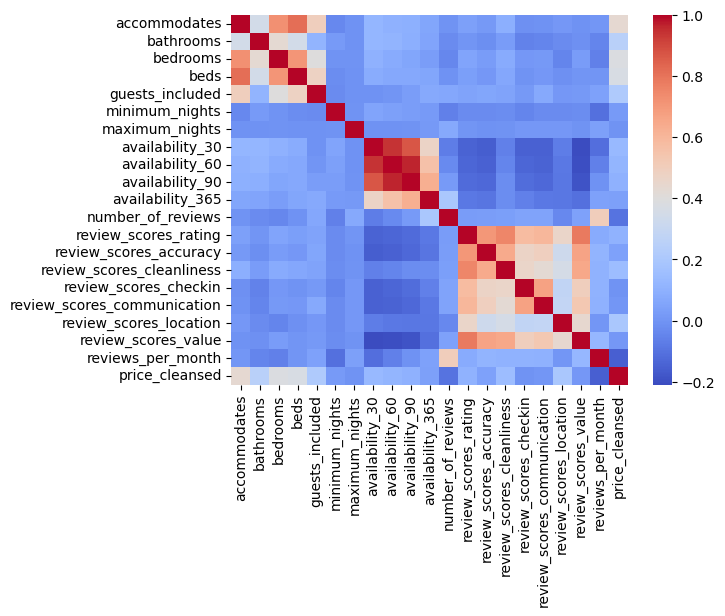

In [240]:
sns.heatmap(bos_listing[numerical_cols].corr(), cmap='coolwarm', annot=False);
# property type variables have higher correlation with price

In [ ]:
fill_with_mode_cols = ['host_listings_count',
                      'host_identity_verified',
                       'property_type',
                       'bathrooms',
                       'bedrooms',
                       'beds']

In [353]:
def clean_data(df, x_cols, fill_with_mode_cols):
    # clean price
    df['price_cleansed'] = df.price.apply(priceClean)
    # calculate host tenure
    df['host_tenure'] = pd.to_datetime(df['last_scraped']) - pd.to_datetime(df['host_since'])
    df['host_tenure'] = df['host_tenure'].dt.days
    # create review score groups
    create_review_category(df)
    # assign city to 1 value
    df['city'] = df['city'].mode()[0] 
    
    # handle missing values
    # fill with min, no host_since information more likely a new host
    df['host_tenure'] = df['host_tenure'].fillna(df['host_tenure'].min())
    # fill with mode
    for col in fill_with_mode_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

    # fill with group mode
    # compute the mode of the zipcode for each neighborhood
    zipcode_mode = df.groupby('neighbourhood_cleansed')['zipcode'].transform(lambda x: x.mode().iloc[0])

    # fill in the missing values in the zipcode column using the computed modes
    df['zipcode'] = df['zipcode'].fillna(zipcode_mode)
    
    X = df[x_cols].copy()
    y = df['price_cleansed'].copy()
    
    # standardize numeric columns
    scaler = StandardScaler()
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
    
    # create dummy variables
    cat_cols = df.select_dtypes(include=['object','category']).columns
    for col in cat_cols:
        try:
            # for each cat add dummy var, drop original column
            X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue
    
    # train test set split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [358]:
X_train, X_test, y_train, y_test = clean_data(sea_listing, use_cols, fill_with_mode_cols)

In [359]:
lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [360]:
train_score

0.6013384296589941

In [361]:
test_score

0.6003586702227077

In [364]:
# try combine 2 data sets to train and test

In [365]:
combined = pd.concat([sea_listing, bos_listing])

In [368]:
combined.shape

(7403, 98)

In [369]:
X_train, X_test, y_train, y_test = clean_data(combined, use_cols, fill_with_mode_cols)
lm_model = LinearRegression() # Instantiate
lm_model.fit(X_train, y_train) #Fit

#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)

In [370]:
train_score

0.42044337206710636

In [371]:
test_score

0.5442720327721353

In [376]:
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=42)

# Fit the model using the training data
rf_reg.fit(X_train, y_train)

# Predict on the test data
y_test_preds = rf_reg.predict(X_test)
# train set 
y_train_preds = rf_reg.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print("Train Score: ", train_score, " Test Score: ", test_score)

Train Score:  0.8963319808796207  Test Score:  0.5510871943599033


In [379]:
rf = RandomForestRegressor()

param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2']}

grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [380]:
grid_search.best_score_

0.43859402812521847

In [381]:
X_train_bos, X_test_bos, y_train_bos, y_test_bos = clean_data(bos_listing, use_cols, fill_with_mode_cols)

In [403]:
def fit_rf(X_train, X_test, y_train, y_test, max_depth=15):
    rf_reg = RandomForestRegressor(n_estimators=300, max_depth=max_depth, 
                                   max_features='sqrt',
                                   random_state=42)

    # Fit the model using the training data
    rf_reg.fit(X_train, y_train)

    # Predict on the test data
    y_test_preds = rf_reg.predict(X_test)
    # train set 
    y_train_preds = rf_reg.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    print("Train Score: ", train_score, " Test Score: ", test_score)
    
    return rf_reg, train_score, test_score

In [388]:
rf_bos, train_score_bos, test_score_bos = fit_rf(X_train_bos, X_test_bos, y_train_bos, y_test_bos)

Train Score:  0.8815395654734772  Test Score:  0.23208644718081706


In [399]:
X_train_sea, X_test_sea, y_train_sea, y_test_sea = clean_data(sea_listing, use_cols, fill_with_mode_cols)
rf_sea, train_score_sea, test_score_sea = fit_rf(X_train_sea, X_test_sea, y_train_sea, y_test_sea)

Train Score:  0.9133864615493361  Test Score:  0.605254751157583


In [404]:
rf_sea, train_score_sea, test_score_sea = fit_rf(X_train_sea, X_test_sea, y_train_sea, y_test_sea, max_depth=15)

Train Score:  0.8689573854484542  Test Score:  0.6111217531476474


In [397]:
X_test_

,host_tenure,host_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,...,review_score_group_92,review_score_group_93,review_score_group_94,review_score_group_95,review_score_group_96,review_score_group_97,review_score_group_98,review_score_group_99,review_score_group_100,review_score_group_N/A
3163,-0.447349,-0.338421,-0.585424,-0.441008,-0.339391,-0.601045,-0.406805,-0.244708,-0.017200,0.608601,...,0,0,0,0,1,0,0,0,0,0
3133,-0.540793,-0.338421,-0.585424,-0.441008,-0.339391,-0.601045,-0.406805,-0.244708,-0.016528,0.800285,...,0,0,0,0,1,0,0,0,0,0
937,0.540250,-0.320887,2.787861,1.556484,2.320097,2.366925,-0.406805,-0.132005,-0.016528,-0.253974,...,0,0,0,0,0,0,0,0,0,0
196,-0.178297,-0.332576,-0.023210,-0.441008,-0.339391,0.388278,-0.406805,-0.132005,-0.017184,0.416918,...,0,0,0,0,0,1,0,0,0,0
2852,0.158421,-0.344265,-0.585424,-0.441008,-0.339391,-0.601045,-0.406805,-0.019303,-0.017185,1.662860,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,-0.610070,-0.332576,-0.585424,-0.441008,-1.669134,-0.601045,-0.406805,0.206103,-0.017196,-0.829024,...,0,0,0,0,0,0,0,0,0,1
365,1.568127,-0.332576,1.663433,-0.441008,2.320097,0.388278,-0.406805,-0.132005,-0.017194,-0.829024,...,0,0,0,0,0,0,0,0,0,0
1940,0.886635,-0.303353,-0.585424,-0.441008,-1.669134,-0.601045,2.432384,0.656914,-0.016528,-0.829024,...,0,0,1,0,0,0,0,0,0,0
276,0.972023,-0.332576,1.101219,-0.441008,0.990353,1.377601,2.432384,-0.019303,-0.016984,-0.253974,...,0,0,0,0,0,0,0,0,1,0


<Axes: ylabel='price_cleansed'>

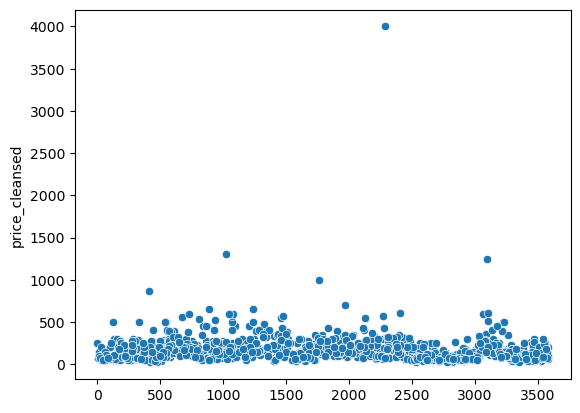

In [395]:
sns.scatterplot(y_test_bos)

<Axes: ylabel='price_cleansed'>

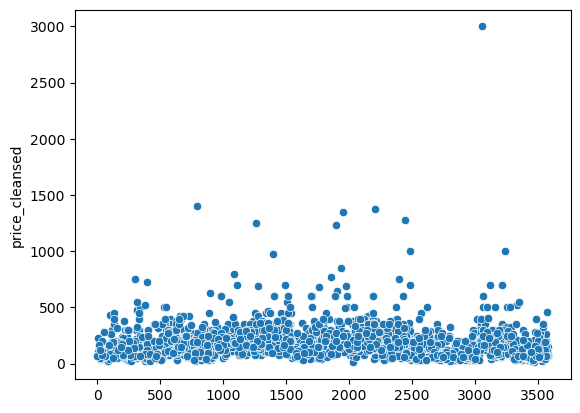

In [396]:
sns.scatterplot(y_train_bos)

In [375]:
use_cols = ['host_tenure', # use to calculate tenur of the host
           'host_is_superhost', # host feature
           'host_listings_count', # host feature
            'host_identity_verified', # host feature
           'neighbourhood_cleansed', # listing location feature
           'city', # include city to combine 2 data sets, more data points in training set
           'zipcode', # listing location feature
           'is_location_exact', # listing location feature
           'property_type', # listing property feature
           'room_type', # listing property feature
           'accommodates', # listing property feature
            'bathrooms', # listing property feature
            'bedrooms', # listing property feature
            'beds', # listing property feature
            'bed_type', # listing property feature
            'guests_included', # listing policy feature
            'minimum_nights', # listing policy feature
            'maximum_nights', # listing policy feature
             'availability_30', # listing popularity feature
             'availability_60', # listing popularity feature
             'availability_90', # listing popularity feature
             'availability_365', # listing popularity feature
            'number_of_reviews', # listing review feature
            'review_score_group', # listing review feature, need preprocess
            'instant_bookable', # listing policy feature
            'cancellation_policy' # listing policy feature
           ]

fill_with_mode_cols = ['host_is_superhost',
                       'host_listings_count',
                       'host_identity_verified',
                       'property_type',
                       'bathrooms',
                       'bedrooms',
                       'beds']

category_cols = ['host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed',
   'city', 'zipcode', 'is_location_exact', 'property_type', 'room_type',
   'bed_type', 'review_score_group', 'instant_bookable', 'cancellation_policy']